In [1]:
% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from deep_visual_odometry.kitti_utils import KITTIdata
from matplotlib import pyplot as plt

In [3]:
basedir = 'dataset'

In [4]:
from deep_visual_odometry.odometry_model import OdomModel

In [5]:
batch_size = 256         # Sequences per batch
num_steps = 16         # Number of sequence steps per batch
rnn_size = 128          # Size of hidden layers in rnn_cell
num_layers = 2           # Number of hidden layers
learning_rate = 0.001   #learning rate

In [27]:
kitti_data = KITTIdata(basedir, 
                       sequences = ['00', '01'],
                       sequence_len = 32,
                       val_frac = 0,
                       test_frac = 0,
                       img_size=(150,50))

completed load sequence 00 data
completed load sequence 01 data


In [28]:
kitti_data.normalize()

normalized data


In [ ]:
inputs, inter_inputs, targets = kitti_data.get_series_batch_train(batch_size)

In [30]:
model = OdomModel(batch_size = 256, 
                  num_steps = 32,
                  cell_type = 'GRU',
                  rnn_size = 128,
                  num_layers = 2,
                  learning_rate = 0.001)
model.train(kitti_data, max_count = 350, save_every_n = 1000, sequences = ['00'])

output size (256, 32, 128)
seq_output shape (256, 32, 128)
shape of outputs (256, 32, 3)
shape of targets (256, 32, 3)
step: 50  loss: 0.1580  3.7502 sec/batch
step: 100  loss: 0.1231  3.7039 sec/batch
step: 150  loss: 0.1123  3.7590 sec/batch
step: 200  loss: 0.1013  3.7478 sec/batch
step: 250  loss: 0.0989  3.7291 sec/batch
step: 300  loss: 0.0893  3.7128 sec/batch
step: 350  loss: 0.0801  3.7028 sec/batch


In [ ]:
#inputs_test, interinputs_test, targets_test = kitti_data.load_all_sequences(mode = 'train', sequences = ['01'])

In [31]:
model = OdomModel(batch_size = 256, 
                  num_steps = 32,
                  cell_type = 'GRU',
                  rnn_size = 128,
                  num_layers = 2,
                  learning_rate = 0.001,
                  sampling = True)

output size (1, 1, 128)
seq_output shape (1, 1, 128)
shape of outputs (1, 1, 3)
shape of targets (1, 1, 3)


In [33]:
inputs, inter_inputs, targets = kitti_data.get_full_sequence(sequence = '00')
inter_inputs.shape

(4540, 5)

In [38]:
checkpoint = tf.train.latest_checkpoint('checkpoints')
predictions = model.test(checkpoint, inter_inputs, priming_len = 1000)
predictions.shape

INFO:tensorflow:Restoring parameters from checkpoints/i351_l128.ckpt


(4540, 3)

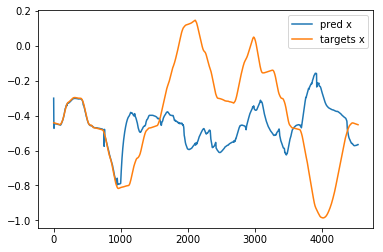

In [39]:
j = 0
plt.plot(predictions[:,j],label = 'pred x')
plt.plot(targets[:,j],label = 'targets x')
plt.legend()
plt.show()

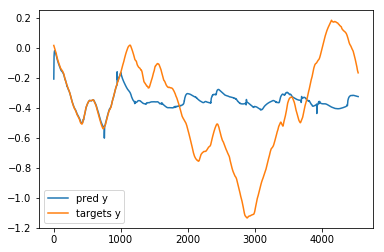

In [40]:
j = 1
plt.plot(predictions[:,j],label = 'pred y')
plt.plot(targets[:,j],label = 'targets y')
plt.legend()
plt.show()

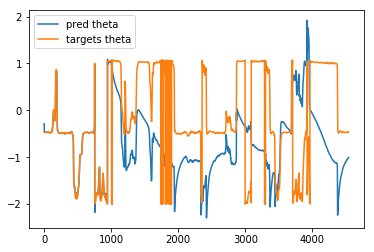

In [41]:
j = 2
plt.plot(predictions[:,j],label = 'pred theta')
plt.plot(targets[:,j],label = 'targets theta')
plt.legend()
plt.show()